In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]
 
MAX_THRESHOLD_CONST = 4.43 #CONSTANT WILL BE mean of rats for stim max / threshold for EVERY possible combination... ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)
NUM_THRESHOLD_POINTS = 500

In [ ]:
src = f"/home/{USER}/repos/rat-mapping-paper/reports/non-hierarchical/J_RCML_000/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


a (4000, 8, 21, 6)
b (4000, 8, 21, 6)
L (4000, 8, 21, 6)
ℓ (4000, 8, 21, 6)
H (4000, 8, 21, 6)


In [3]:
a = posterior_samples[site.a]

subjects = sorted(df['participant'].unique())
positions = sorted(df['compound_position'].unique())
muscles = model.response


In [4]:
positions = sorted(df['compound_position'].unique())
positions = encoder_dict['compound_position'].inverse_transform(positions)
positions

array(['-C5L', '-C5M', '-C6L', '-C6M', '-C7L', '-C7M', '-C8L', '-C8M',
       'C5L-C6L', 'C5M-C5L', 'C5M-C6L', 'C5M-C6M', 'C6L-C7L', 'C6M-C6L',
       'C6M-C7L', 'C6M-C7M', 'C7L-C8L', 'C7M-C7L', 'C7M-C8L', 'C7M-C8M',
       'C8M-C8L'], dtype=object)

In [25]:
# pos_set = [(0,1), (2,3), (4,5), (6,7)]
pos_set = [(8,11), (12,15), (16,19)]

In [26]:
a[:,0,(0,2),0].shape

(4000, 2)

In [27]:
norm_y = []
norm_x = []

for subject_ind, subject in enumerate(subjects):
    for p in pos_set:
        for m,muscle in enumerate(muscles):
        # Fix the subject index and size index
            a_temp = a[:, subject_ind, p, m]
            mean_thres = np.nanmean(a_temp[:,1],axis=(0))
            curr_params = [
                params[:, subject_ind, p, m, None] for params in params
            ]

            x_temp = np.array([1.2*mean_thres])[None, None, None, None, :]

            temp_thresh = F.rectified_logistic(
                x_temp, #x_temp
                *curr_params
            )
            # Remove offset
            temp_thresh = temp_thresh - curr_params[2]
            norm_y.append(temp_thresh)
            norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects), len(pos_set), len(muscles),*norm_x.shape[3:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects),len(pos_set),len(muscles),*norm_y.shape[3:])
norm_y = ma.masked_invalid(norm_y)

/tmp/ipykernel_2767929/3676698412.py:9: RuntimeWarning: Mean of empty slice
  mean_thres = np.nanmean(a_temp[:,1],axis=(0))


In [28]:
norm_y.shape

(8, 3, 6, 4000, 2, 1)

In [29]:
y_means = ma.mean(norm_y, axis=(3,5))

In [30]:
y_means.shape

(8, 3, 6, 2)

In [31]:
y_diffs = y_means[:,:, :,:,None] - y_means[:,:,:,None,:]

In [32]:
y_diffs.shape

(8, 3, 6, 2, 2)

In [33]:
y_diffs_means = ma.mean(y_diffs,axis=(1,2))

In [36]:
labels = ["L", "M"]

In [34]:
pvalues = []
for i in range(len(labels)):
    for i2 in range(len(labels)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(y_diffs_means[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(labels), len(labels))


<Axes: >

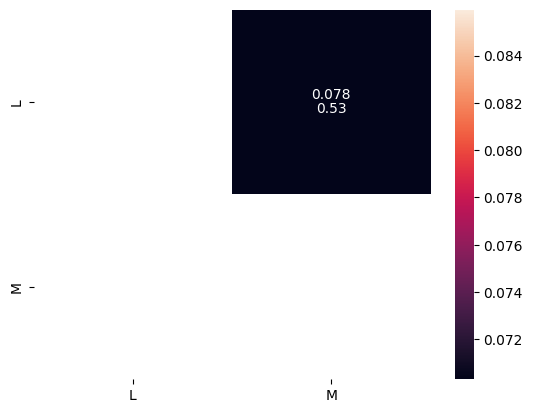

In [37]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(y_diffs_means.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)